# EDA On Wifire Runs Dataset
Key Questions: 
- What existing features are useful in predicting the run time of a wifire simulation? 
- What features can be created to assist in eventually training a prediction model?
- What is the correlation between different variables and runtime?

# Setup

In [70]:
from tqdm import tqdm
import pandas as pd
from pprint import pprint
from rich import print as show
from datetime import datetime, timedelta
import time
import seaborn as sns
import ast

In [71]:
simulation_runs = pd.read_csv("simulation_runs.csv")
simulation_runs

,Unnamed: 0,path,time_scraped,canopy_moisture,dz,extent,extent_fmt,fire_grid,fuel,ignition,...,run_max_mem_rss_bytes,run_start,seed,sim_time,surface_moisture,threads,timestep,topo,wind_direction,wind_speed
0,38,burnpro3d/d/00/60/run_00601423-00ba-4edc-85de-...,2023-07-27T17:04:03.155927,1.00,NaN,"[-928246.0, 1477596.0, -927440.0, 1476900.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,1934680,2023-06-20T15:13:20.118932-07:00,-1,4503,0.10,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",65.0,2.235
1,41,burnpro3d/d/00/6d/run_006d5586-0a9c-448a-b307-...,2023-07-27T17:04:03.155927,0.90,NaN,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2470180,2023-06-15T11:08:55.640920-07:00,-1,11382,0.05,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",90.0,4.470
2,77,burnpro3d/d/00/d5/run_00d57d95-2227-40ea-b1a8-...,2023-07-27T17:04:03.155927,0.95,NaN,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,517424,2023-06-27T16:04:29.825894-07:00,-1,3937,0.12,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",270.0,2.235
3,10,burnpro3d/d/01/37/run_0137bb44-361e-48ed-8feb-...,2023-07-27T17:05:28.453250,1.10,NaN,"[885288.0, 870390.0, 886242.0, 869286.0]","[[x1, y1], [x2, y2]]",NaN,"{'density': None, 'dx': 2, 'dy': 2, 'height': ...","{'dat': None, 'id': '121dc89e-b034-479a-b0da-c...",...,2454040,2023-04-09T18:24:10.951246-07:00,-1,4921,0.10,1,600,NaN,137.0,3.000
4,14,burnpro3d/d/01/40/run_0140601b-6702-452f-8bc0-...,2023-07-27T17:05:28.453250,1.00,NaN,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,3919432,2023-06-20T09:53:36.922562-07:00,-1,14997,0.15,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",360.0,4.470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,59,burnpro3d/d/ee/fb/run_eefbeebe-1c01-4056-a3b8-...,2023-07-28T12:21:19.720857,1.10,NaN,"[-1398056.0, 2815704.0, -1397036.0, 2814900.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2565376,2023-06-19T13:31:23.989481-07:00,-1,6906,0.15,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",240.0,2.235
1464,66,burnpro3d/d/ef/0c/run_ef0ccf36-708a-4c47-99dd-...,2023-07-28T12:21:19.720857,0.90,NaN,"[1298064.0, 942076.0, 1298868.0, 941272.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,1337528,2023-06-23T16:34:47.423739-07:00,-1,9463,0.10,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",120.0,2.235
1465,79,burnpro3d/d/ef/2b/run_ef2bab51-c661-4681-aa2c-...,2023-07-28T12:21:19.720857,0.00,NaN,"[-1959092.0, 1310426.0, -1958552.0, 1309880.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,452052,2023-06-14T12:26:08.764889-07:00,-1,4005,0.10,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",90.0,6.705
1466,81,burnpro3d/d/ef/2f/run_ef2fe326-6f49-4c83-a598-...,2023-07-28T12:21:19.720857,1.00,NaN,"[123782.0, 1223754.0, 124586.0, 1222950.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2456484,2023-07-13T11:18:09.854595-07:00,-1,9396,0.10,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",90.0,6.705


In [11]:
# [-928246.0, 1477596.0, -927440.0, 1476900.0]

def calculate_area(str):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
    L = ast.literal_eval(str)
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    
    area = (x2-x1) * (y2-y1)
    return abs(area)


# DataFrame Reshaping
add area column generated from `extent` and only extract relevant columns

In [37]:
useful_columns = [
    "sim_time",
    "run_end",
    "run_start",
    "extent",
    "surface_moisture",
    "timestep",
    "wind_direction",
    "wind_speed",
    "canopy_moisture"
]
run_data = simulation_runs.get(useful_columns)
column = run_data.apply(lambda row: calculate_area(row["extent"]), axis=1)
run_data = run_data.assign(area=column)
run_data.head()

,sim_time,run_end,run_start,extent,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,area
0,4503,2023-06-20T16:44:36.032464-07:00,2023-06-20T15:13:20.118932-07:00,"[-928246.0, 1477596.0, -927440.0, 1476900.0]",0.10,600,65.0,2.235,1.00,560976.0
1,11382,2023-06-15T13:51:13.573728-07:00,2023-06-15T11:08:55.640920-07:00,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]",0.05,600,90.0,4.470,0.90,1981888.0
2,3937,2023-06-27T16:12:51.127014-07:00,2023-06-27T16:04:29.825894-07:00,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]",0.12,600,270.0,2.235,0.95,359488.0
3,4921,2023-04-09T19:36:16.198481-07:00,2023-04-09T18:24:10.951246-07:00,"[885288.0, 870390.0, 886242.0, 869286.0]",0.10,600,137.0,3.000,1.10,1053216.0
4,14997,2023-06-20T12:23:45.540506-07:00,2023-06-20T09:53:36.922562-07:00,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]",0.15,600,360.0,4.470,1.00,648024.0


<Axes: xlabel='area', ylabel='sim_time'>

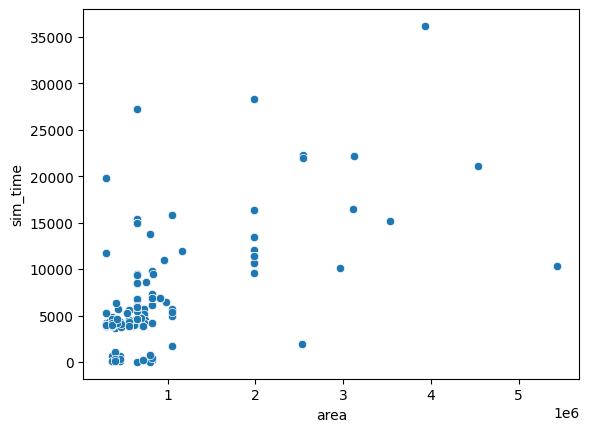

In [39]:
import seaborn as sns
sns.scatterplot(x=run_data['area'], y=run_data['sim_time'])

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


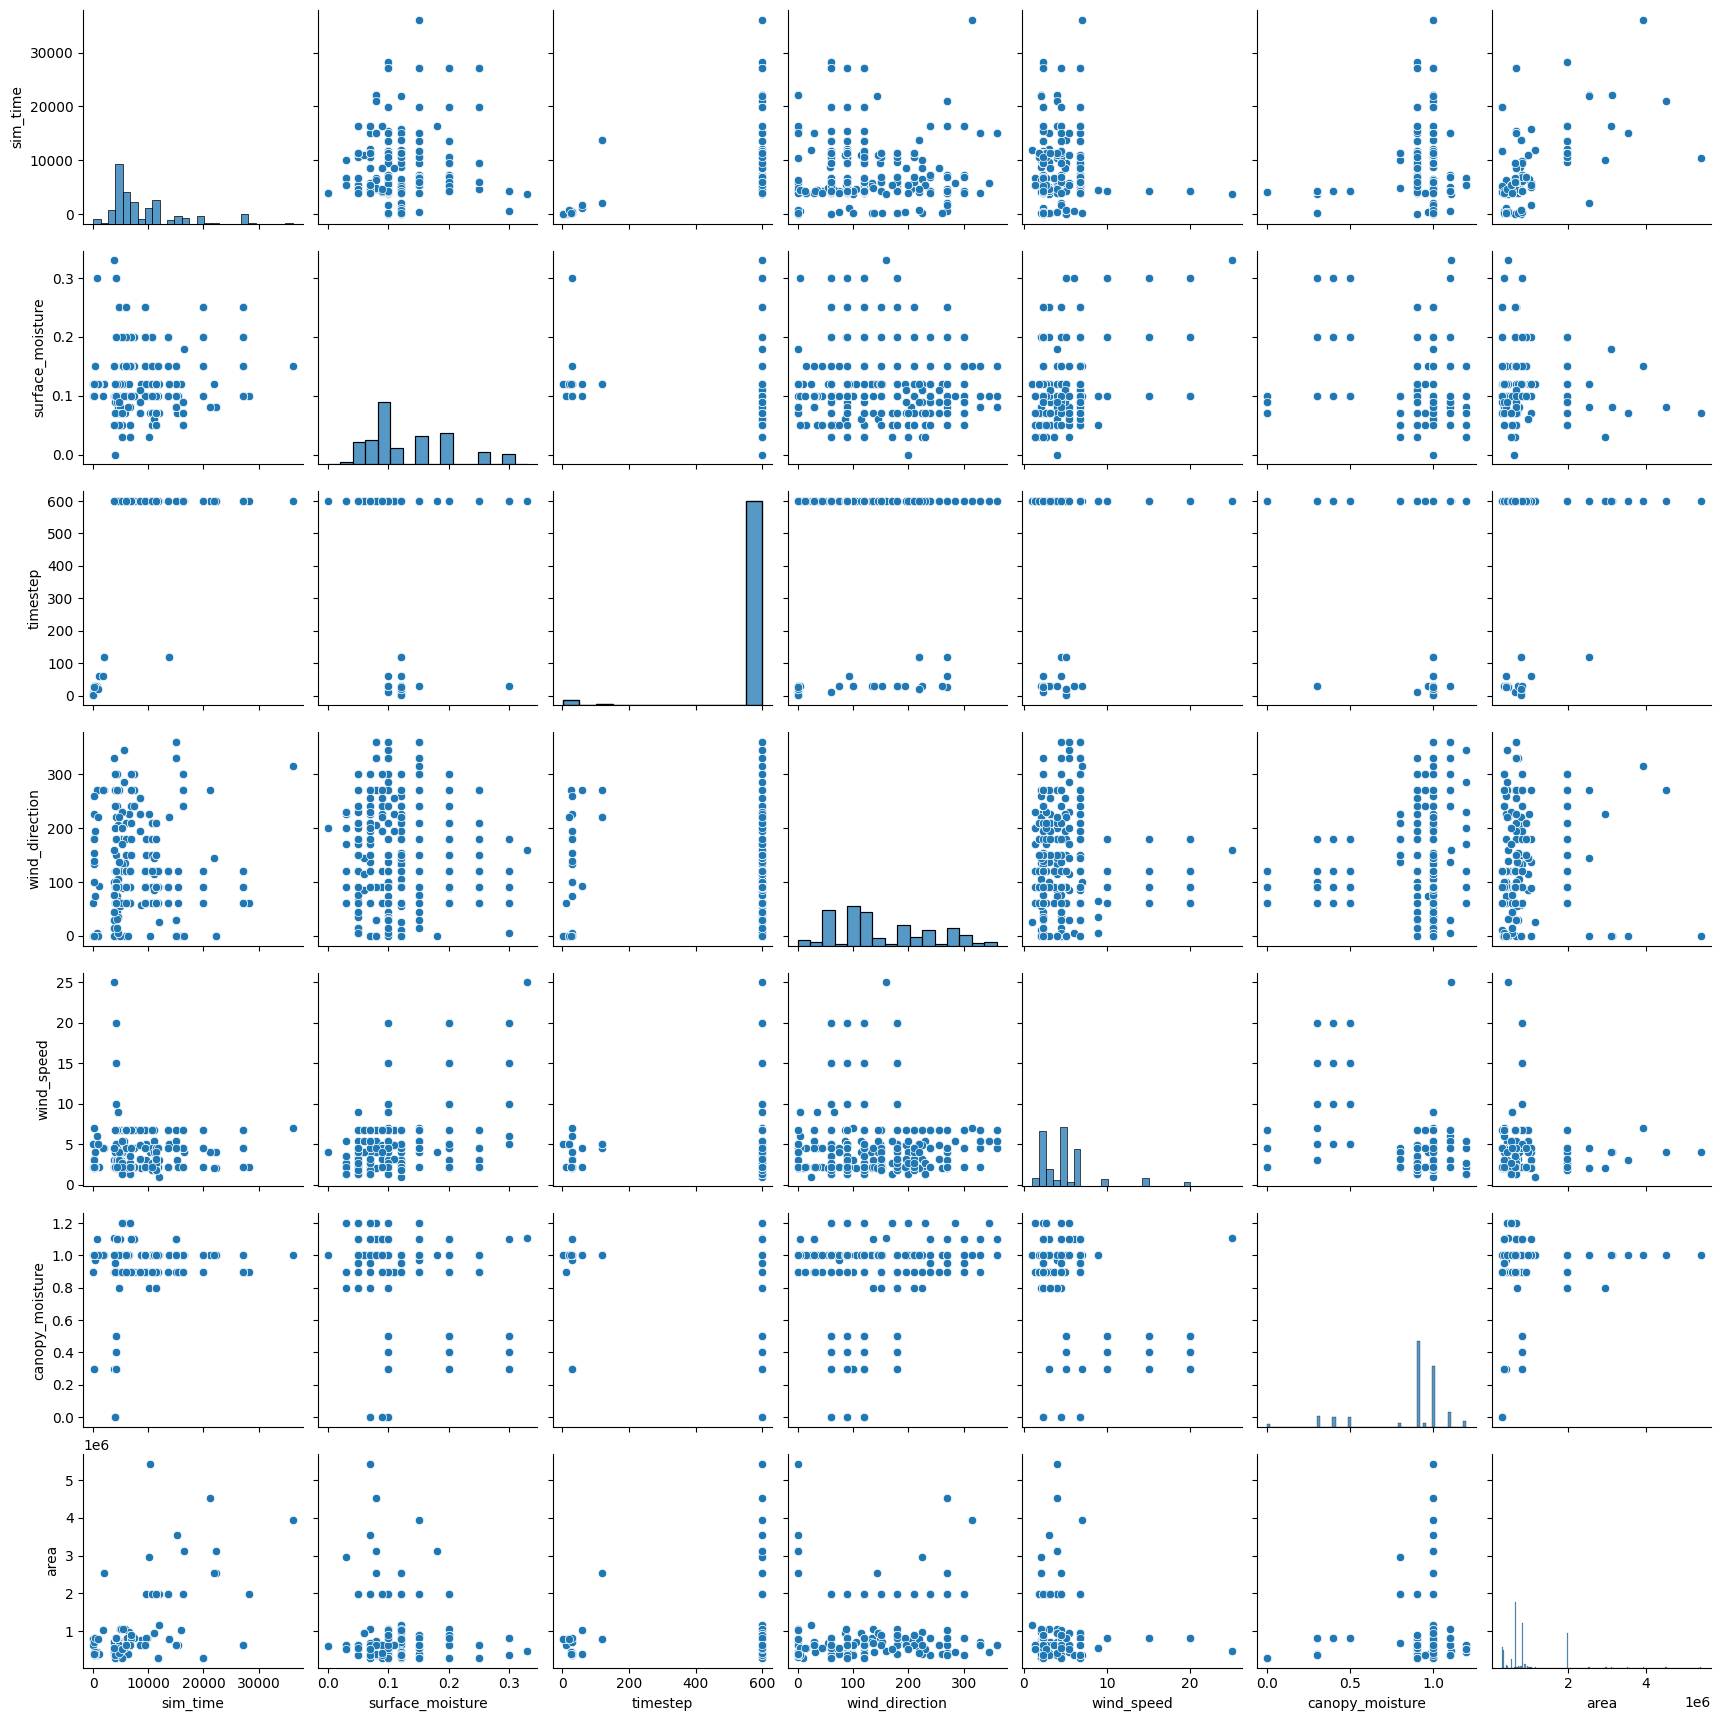

In [40]:
sns.pairplot(run_data)